In [234]:
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle scipy==1.10.1
!pip install xgboost
!pip install -q --no-deps numerai-tools
!pip install pmdarima


In [235]:
from numerapi import SignalsAPI
api = SignalsAPI()
api.download_dataset(
	"signals/v1.0/train.parquet",
	"train.parquet"
)
api.download_dataset(
	"signals/v1.0/validation.parquet",
	"validation.parquet"
)
api.download_dataset(
	"signals/v1.0/live.parquet",
	"live.parquet"
)
api.download_dataset(
	"signals/v1.0/live_example_preds.parquet",
	"live_example_preds.parquet"
)
api.download_dataset(
	"signals/v1.0/validation_example_preds.parquet",
	"validation_example_preds.parquet"
)

'validation_example_preds.parquet'

In [236]:
import pandas as pd
import numpy as np
import statsmodels
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics  import mean_squared_error
from matplotlib.ticker import FuncFormatter
import seaborn as sns


In [237]:
PAISES = {
    'AT': 'Austria',
    'AU': 'Australia',
    'BE': 'Belgium',
    'BR': 'Brazil',
    'CA': 'Canada',
    'CH': 'Switzerland',
    'CZ': 'Czech Republic',
    'DE': 'Germany',
    'DK': 'Denmark',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GB': 'United Kingdom',
    'GR': 'Greece',
    'HK': 'Hong Kong',
    'HU': 'Hungary',
    'ID': 'Indonesia',
    'IE': 'Ireland',
    'IL': 'Israel',
    'IT': 'Italy',
    'JP': 'Japan',
    'KR': 'Korea',
    'MX': 'Mexico',
    'MY': 'Malaysia',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'NZ': 'New Zealand',
    'PH': 'Philippines',
    'PL': 'Poland',
    'PT': 'Portugal',
    'SE': 'Sweden',
    'SG': 'Singapore',
    'ZA': 'South Africa',
    'TH': 'Thailand',
    'TR': 'Turkey',
    'TW': 'Taiwan',
    'UK': 'United Kingdom',
    'US': 'United States',
    'USA': 'United States',
    'Australia': 'Australia',
    'Austria': 'Austria',
    'Belgium': 'Belgium',
    'Brazil': 'Brazil',
    'Canada': 'Canada',
    'Czech Republic': 'Czech Republic',
    'Denmark': 'Denmark',
    'Finland': 'Finland',
    'France': 'France',
    'Germany': 'Germany',
    'Greece': 'Greece',
    'Hong Kong': 'Hong Kong',
    'Hungary': 'Hungary',
    'Indonesia': 'Indonesia',
    'Ireland': 'Ireland',
    'Israel': 'Israel',
    'Italy': 'Italy',
    'Japan': 'Japan',
    'Korea': 'Korea',
    'Malaysia': 'Malaysia',
    'Mexico': 'Mexico',
    'Netherlands': 'Netherlands',
    'New Zealand': 'New Zealand',
    'Norway': 'Norway',
    'Philippines': 'Philippines',
    'Poland': 'Poland',
    'Portugal': 'Portugal',
    'Singapore': 'Singapore',
    'South Africa': 'South Africa',
    'Spain': 'Spain',
    'Sweden': 'Sweden',
    'Switzerland': 'Switzerland',
    'Taiwan': 'Taiwan',
    'Thailand': 'Thailand',
    'Turkey': 'Turkey'
}

In [238]:
df_train = pd.read_parquet(
    f"train.parquet"
)

df_validation = pd.read_parquet(
    f"validation.parquet"
)

In [239]:
df_signal=pd.concat([df_train,df_validation])
df_signal['Country'] = df_signal['feature_country'].map(PAISES)
df_signal.columns

Index(['numerai_ticker', 'composite_figi', 'date', 'data_type',
       'feature_impact_cost_factor', 'feature_beta_factor',
       'feature_volatility_factor', 'feature_momentum_12w_factor',
       'feature_momentum_26w_factor', 'feature_momentum_52w_factor',
       'feature_momentum_52w_less_4w_factor',
       'feature_trix_130d_country_ranknorm',
       'feature_trix_60d_country_ranknorm',
       'feature_rsi_130d_country_ranknorm', 'feature_rsi_60d_country_ranknorm',
       'feature_rsi_90d_country_ranknorm',
       'feature_ppo_60d_90d_country_ranknorm',
       'feature_ppo_60d_130d_country_ranknorm', 'feature_country',
       'feature_adv_20d_factor', 'feature_market_cap_factor',
       'feature_price_factor', 'feature_earnings_yield_factor',
       'feature_dividend_yield_factor', 'feature_book_to_price_factor',
       'feature_value_factor', 'feature_growth_factor', 'target',
       'target_raw_return_20', 'target_raw_return_60',
       'target_factor_neutral_20', 'target_factor

In [240]:
columns_analisis=['date', 'Country','data_type','numerai_ticker','feature_impact_cost_factor', 'feature_beta_factor',
       'feature_volatility_factor', 'feature_momentum_12w_factor',
       'feature_momentum_26w_factor', 'feature_momentum_52w_factor',
       'feature_momentum_52w_less_4w_factor',
       'feature_trix_130d_country_ranknorm',
       'feature_trix_60d_country_ranknorm',
       'feature_rsi_130d_country_ranknorm', 'feature_rsi_60d_country_ranknorm',
       'feature_rsi_90d_country_ranknorm',
       'feature_ppo_60d_90d_country_ranknorm',
       'feature_ppo_60d_130d_country_ranknorm', 'feature_country',
       'feature_adv_20d_factor', 'feature_market_cap_factor',
       'feature_price_factor', 'feature_earnings_yield_factor',
       'feature_dividend_yield_factor', 'feature_book_to_price_factor',
       'feature_value_factor', 'feature_growth_factor', 'target_factor_neutral_20',]

In [ ]:
df_analisis = df_signal[columns_analisis].copy()


In [ ]:
def adfuller_test(riders):
    result = adfuller(riders)
    labels = ['ADF Test Statistic', 'p-value','#Lags used', 'Number of Observations used']
    for value,label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('strong evidence against the null hypothesis(Ho), reject the null hypothesis, data is stationary')
    else:
        print('weak evidence against the null hypothesis(Ho), data is not stationary')

In [ ]:
def generar_eda_empresa(df_analisis, empresa):
    df_filtrado = df_analisis[df_analisis["numerai_ticker"].str.contains(empresa, na=False)]
    fecha_inicio = df_filtrado["date"].min()  # Fecha de inicio
    fecha_fin = df_filtrado["date"].max()     # Fecha de fin
    frecuencia = 'W-FRI'

    fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=frecuencia)

    # Crear un DataFrame con la columna de fechas
    df = pd.DataFrame(fechas, columns=['date'])

    df['date'] = df['date'].dt.strftime('%Y-%m-%d')


    #df['date'] = pd.to_datetime(df["date"])
    df_filtrado['date'] = pd.to_datetime(df_filtrado["date"])
    # df_filtrado['date'] = df_filtrado['date'].dt.strftime('%Y-%m-%d')

    # df_filtrado

    # df = df.merge(df_filtrado, on="date", how="left")
    # df['target_factor_neutral_20'].interpolate(method='linear')
    df_filtrado.set_index('date', inplace=True)

    #df_filtrado_describe =df_filtrado.describe()
    #df_filtrado_describe.to_excel(f"Descriptivo_{empresa}.xlsx")

    df_filtrado["target_movil"] = df_filtrado["target_factor_neutral_20"].rolling(5).mean()
    df_filtrado = df_filtrado.dropna(subset="target_movil")
    df_filtrado=df_filtrado[["target_factor_neutral_20","target_movil"]]
    fig, ax = plt.subplots(figsize=(12, 6))  # Crea la figura y el eje

    # Graficar los datos
    df_filtrado.plot(ax=ax)

    # Añadir un título al gráfico
    fig.suptitle(f'Serie Temporal de {empresa}', fontsize=16)

    # Ajustar el tamaño del gráfico si es necesario (esto se hace en la creación del gráfico)
    # fig.set_size_inches(10, 8)  # Opcional: solo si necesitas cambiar el tamaño después de la creación

    # Guardar el gráfico como imagen
    fig.savefig(f'serie_temporal_{empresa}.png')  # Cambia el nombre del archivo y formato si es necesario

    # Mostrar el gráfico
    plt.show()

    prueba = df_filtrado['target_movil']

    results = seasonal_decompose(prueba, model='additive', extrapolate_trend='freq', period=64)
    fig = results.plot()

    fig.suptitle(f'Descomposición Estacional de la Serie Temporal de {empresa}', fontsize=25)

    # Ajustar el tamaño del gráfico si es necesario
    fig.set_size_inches(10, 8)  # Puedes ajustar el tamaño según tus necesidades

    # Guardar el gráfico como imagen
    fig.savefig(f'descomposicion_estacional_{empresa}.png')  # Cambia el nombre del archivo y formato si es necesario

    # Mostrar el gráfico
    plt.show()

    test_adfuller = adfuller_test(prueba)

    print("----")
    print(test_adfuller)
    print("-----")

    # Crear una figura con dos subgráficos
    fig = plt.figure(figsize=(12, 8))

    # Primer subgráfico: ACF
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(prueba, lags=40, ax=ax1)
    ax1.set_title(f'Función de Autocorrelación (ACF) {empresa}', fontsize=25)


    # Segundo subgráfico: PACF
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(prueba, lags=40, ax=ax2)
    ax2.set_title(f'Función de Autocorrelación Parcial (PACF) {empresa}', fontsize=25)

    # Ajustar el espacio entre subgráficos
    plt.tight_layout()

    # Guardar la figura como imagen
    fig.savefig(f'acf_pacf_{empresa}.png')  # Cambia el nombre del archivo y formato si es necesario

<ipython-input-54-d97a3d2bac1b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['date'] = pd.to_datetime(df_filtrado["date"])
<ipython-input-54-d97a3d2bac1b>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["target_movil"] = df_filtrado["target_factor_neutral_20"].rolling(5).mean()


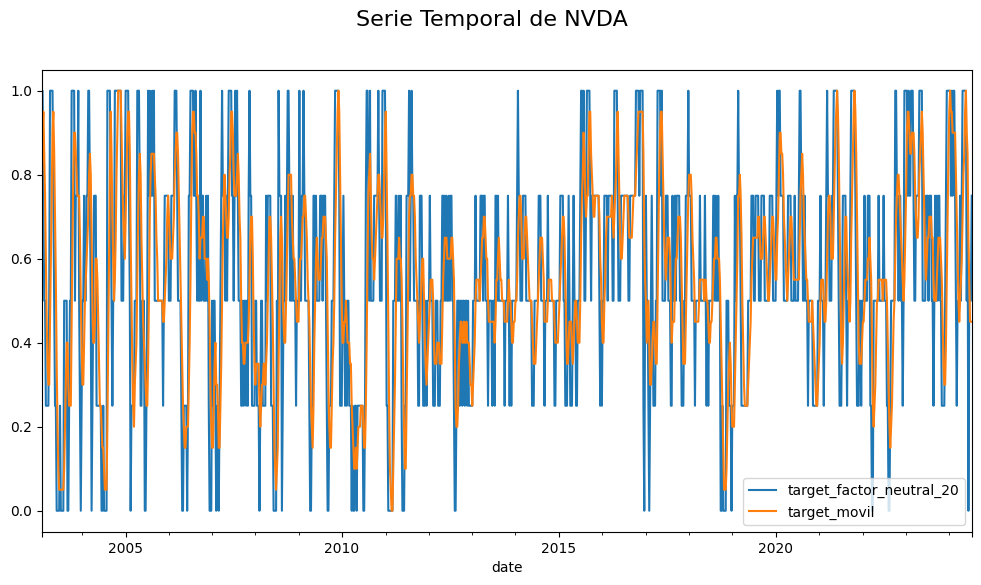

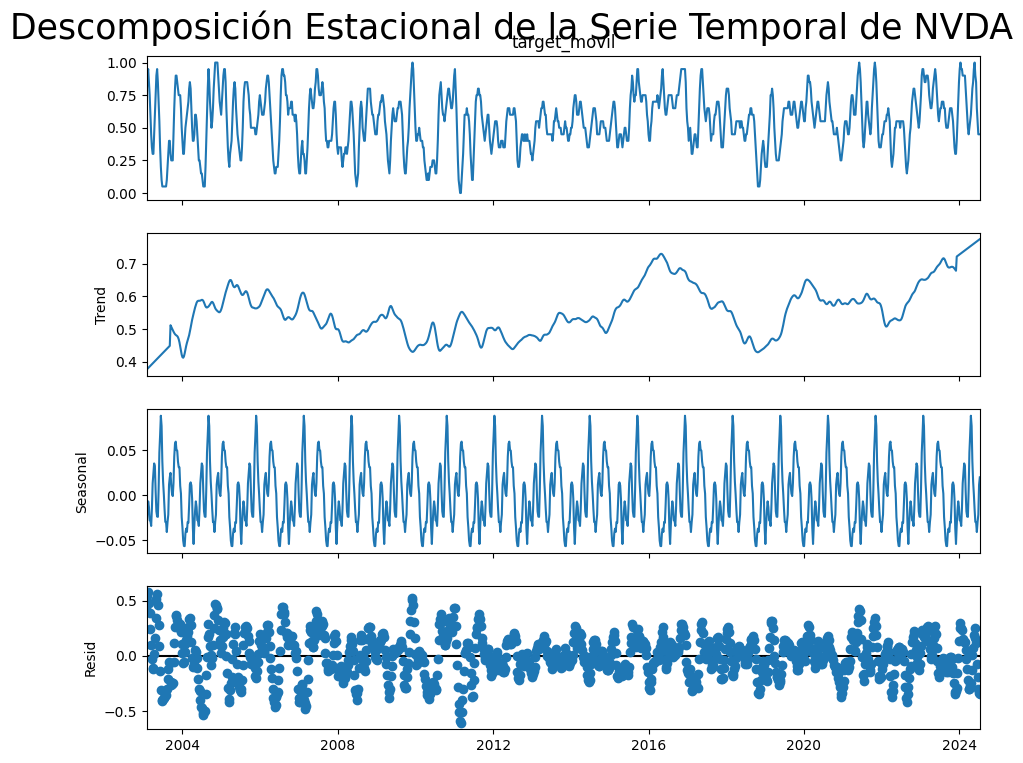

ADF Test Statistic : -6.2913183295532695
p-value : 3.593451320921386e-08
#Lags used : 22
Number of Observations used : 1097
strong evidence against the null hypothesis(Ho), reject the null hypothesis, data is stationary
----
None
-----


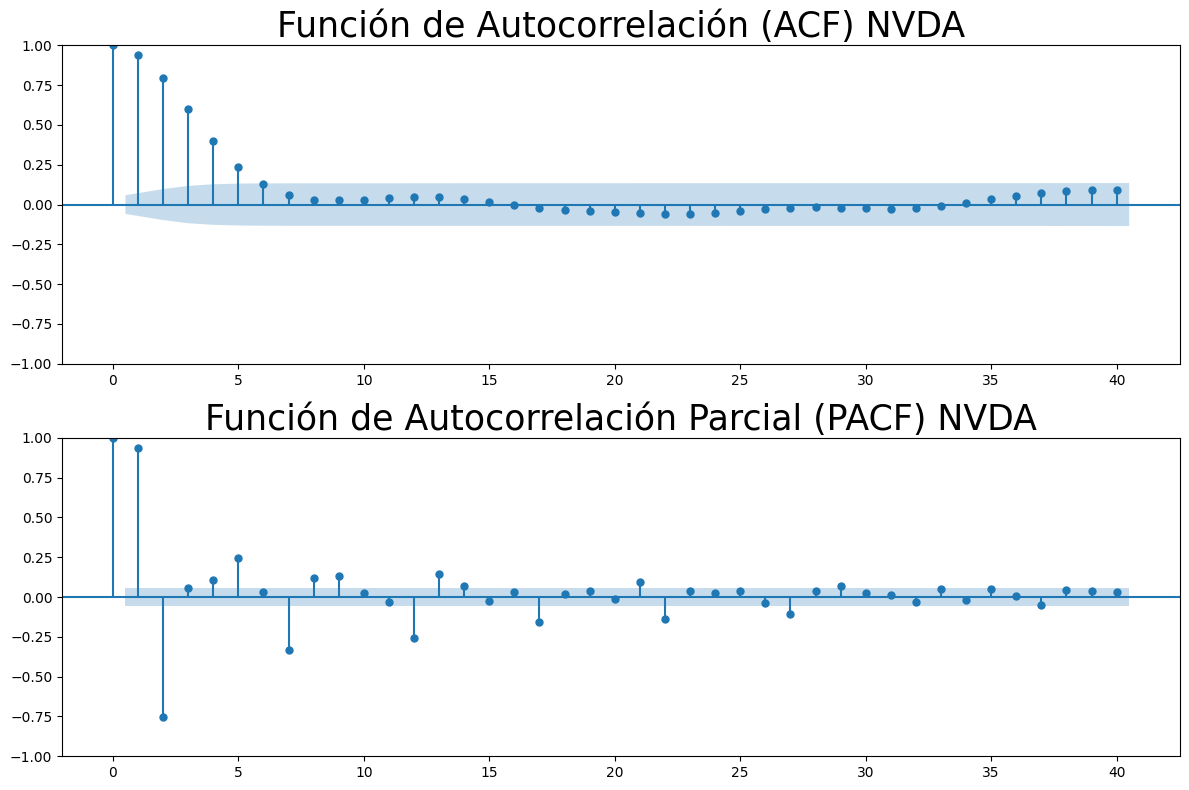

In [ ]:
lista_top_five_sp500 = ["NVDA"]
["NVDA", "AAPL","MSFT","GOOGL","AMZN","TSLA"]


for empresa in lista_top_five_sp500:
    generar_eda_empresa(df_analisis, empresa)

In [ ]:
columns_analisis=['feature_impact_cost_factor', 'feature_beta_factor',
       'feature_volatility_factor', 'feature_momentum_12w_factor',
       'feature_momentum_26w_factor', 'feature_momentum_52w_factor',
       'feature_momentum_52w_less_4w_factor',
       'feature_trix_130d_country_ranknorm',
       'feature_trix_60d_country_ranknorm',
       'feature_rsi_130d_country_ranknorm', 'feature_rsi_60d_country_ranknorm',
       'feature_rsi_90d_country_ranknorm',
       'feature_ppo_60d_90d_country_ranknorm',
       'feature_ppo_60d_130d_country_ranknorm',
       'feature_adv_20d_factor', 'feature_market_cap_factor',
       'feature_price_factor', 'feature_earnings_yield_factor',
       'feature_dividend_yield_factor', 'feature_book_to_price_factor',
       'feature_value_factor', 'feature_growth_factor', 'target_factor_neutral_20',]

In [ ]:

df_filtrado = df_analisis[df_analisis["numerai_ticker"].str.contains('GOOGL', na=False)]
df_filtrado = df_filtrado[columns_analisis].copy()

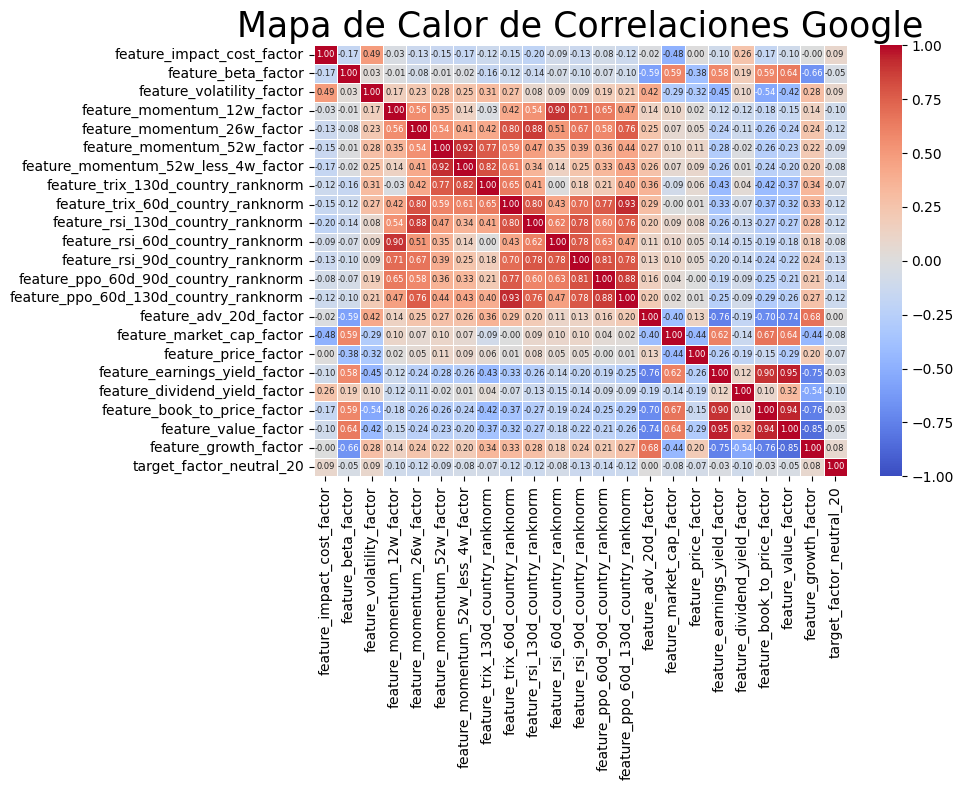

In [ ]:

columns_analisis=['feature_impact_cost_factor', 'feature_beta_factor',
       'feature_volatility_factor', 'feature_momentum_12w_factor',
       'feature_momentum_26w_factor', 'feature_momentum_52w_factor',
       'feature_momentum_52w_less_4w_factor',
       'feature_trix_130d_country_ranknorm',
       'feature_trix_60d_country_ranknorm',
       'feature_rsi_130d_country_ranknorm', 'feature_rsi_60d_country_ranknorm',
       'feature_rsi_90d_country_ranknorm',
       'feature_ppo_60d_90d_country_ranknorm',
       'feature_ppo_60d_130d_country_ranknorm',
       'feature_adv_20d_factor', 'feature_market_cap_factor',
       'feature_price_factor', 'feature_earnings_yield_factor',
       'feature_dividend_yield_factor', 'feature_book_to_price_factor',
       'feature_value_factor', 'feature_growth_factor', 'target_factor_neutral_20',]
df_filtrado = df_analisis[df_analisis["numerai_ticker"].str.contains('GOOGL', na=False)]
df_filtrado = df_filtrado[columns_analisis].copy()
corr_matrix = df_filtrado.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', linewidths=0.5, annot_kws={"size": 6} )
plt.title('Mapa de Calor de Correlaciones Google', fontsize=25)
output_path = 'correlaciones_google.jpg'

# Mostrar el gráfico
plt.tight_layout()
plt.savefig(output_path)
plt.show()

In [241]:
df_train = pd.read_parquet(
    f"train.parquet"
)

df_validation = pd.read_parquet(
    f"validation.parquet"
)

ticket = list(set(df_train["numerai_ticker"]))

In [242]:
full_data = pd.read_parquet(
    f"df.parquet"
)
full_data

,date,ticker,price
0,1999-09-02,AA,55.465801
1,1999-09-02,AES,20.543503
2,1999-09-02,AIRC,7.817583
3,1999-09-02,ANDE,2.199758
4,1999-09-02,ANSS,2.406250
...,...,...,...
203363,2024-08-26,THRM,50.722500
203364,2024-08-26,TOWN,34.270000
203365,2024-08-26,TSN,63.910000
203366,2024-08-26,VMI,286.200012


In [243]:
df_final=pd.concat([df_train,df_validation])
df_final.columns

Index(['numerai_ticker', 'composite_figi', 'date', 'data_type',
       'feature_impact_cost_factor', 'feature_beta_factor',
       'feature_volatility_factor', 'feature_momentum_12w_factor',
       'feature_momentum_26w_factor', 'feature_momentum_52w_factor',
       'feature_momentum_52w_less_4w_factor',
       'feature_trix_130d_country_ranknorm',
       'feature_trix_60d_country_ranknorm',
       'feature_rsi_130d_country_ranknorm', 'feature_rsi_60d_country_ranknorm',
       'feature_rsi_90d_country_ranknorm',
       'feature_ppo_60d_90d_country_ranknorm',
       'feature_ppo_60d_130d_country_ranknorm', 'feature_country',
       'feature_adv_20d_factor', 'feature_market_cap_factor',
       'feature_price_factor', 'feature_earnings_yield_factor',
       'feature_dividend_yield_factor', 'feature_book_to_price_factor',
       'feature_value_factor', 'feature_growth_factor', 'target',
       'target_raw_return_20', 'target_raw_return_60',
       'target_factor_neutral_20', 'target_factor

In [244]:
def extraer_ticket_yahoo(x):
    x=x.split(" ")[0]
    return x

In [245]:
df_final["prueba"]=df_final["numerai_ticker"].apply(extraer_ticket_yahoo)

In [246]:
eligible_tickers = pd.Series(list(set(df_final["prueba"])), name='ticker')
print(f"Number of eligible tickers: {len(eligible_tickers)}")

Number of eligible tickers: 13418


In [247]:

full_data.set_index('date', inplace=True)

# convert yahoo finance tickers back to numerai tickers


print(f"Number of tickers with data: {len(full_data.ticker.unique())}")
full_data.head()

Number of tickers with data: 4329


,ticker,price
date,,
1999-09-02,AA,55.465801
1999-09-02,AES,20.543503
1999-09-02,AIRC,7.817583
1999-09-02,ANDE,2.199758
1999-09-02,ANSS,2.406250


In [248]:
def RSI(prices, interval=14):
  '''Computes Relative Strength Index given a price series and lookback interval
  Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
  See more here https://www.investopedia.com/terms/r/rsi.asp'''

  delta = prices.diff()

  dUp, dDown = delta.copy(), delta.copy()
  dUp[dUp < 0] = 0
  dDown[dDown > 0] = 0

  RolUp = dUp.rolling(interval).mean()
  RolDown = dDown.rolling(interval).mean().abs()

  RS = RolUp / RolDown
  RSI = 100.0 - (100.0 / (1.0 + RS))
  return RSI

In [249]:
constant_tickers = full_data.groupby('ticker')['price'].nunique()
constant_tickers = constant_tickers[constant_tickers <5].index

In [250]:

filtered_data = full_data[~full_data['ticker'].isin(constant_tickers)]

In [251]:
filtered_data

,ticker,price
date,,
1999-09-02,AA,55.465801
1999-09-02,AES,20.543503
1999-09-02,AIRC,7.817583
1999-09-02,ANDE,2.199758
1999-09-02,ANSS,2.406250
...,...,...
2024-08-26,THRM,50.722500
2024-08-26,TOWN,34.270000
2024-08-26,TSN,63.910000


In [252]:
filtered_data['RSI'] = filtered_data['price'].transform(lambda x: RSI(x))

<ipython-input-252-4854b233321b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['RSI'] = filtered_data['price'].transform(lambda x: RSI(x))


In [253]:
date_groups = filtered_data.groupby(filtered_data.index)
filtered_data['RSI_quintile'] = date_groups['RSI'].transform(lambda group: pd.qcut(group, 5, labels=False, duplicates='drop'))
filtered_data.dropna(inplace=True)

filtered_data.head()

<ipython-input-253-c90d7a36fe99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['RSI_quintile'] = date_groups['RSI'].transform(lambda group: pd.qcut(group, 5, labels=False, duplicates='drop'))
<ipython-input-253-c90d7a36fe99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(inplace=True)


,ticker,price,RSI,RSI_quintile
date,,,,
1999-09-02,CLS,21.937500,38.833502,0.0
1999-09-02,CNP,6.986200,44.791982,0.0
1999-09-02,CTBI,5.300616,48.943495,1.0
1999-09-02,DRI,5.780150,51.570632,4.0
1999-09-02,EGY,0.444559,49.176511,1.0


In [254]:
ticker_groups = filtered_data.groupby('ticker')

#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc
num_days = 5
for day in range(num_days+1):
    filtered_data[f'RSI_quintile_lag_{day}'] = ticker_groups['RSI_quintile'].transform(lambda group: group.shift(day))

<ipython-input-254-ae51fb17dff0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'RSI_quintile_lag_{day}'] = ticker_groups['RSI_quintile'].transform(lambda group: group.shift(day))
<ipython-input-254-ae51fb17dff0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f'RSI_quintile_lag_{day}'] = ticker_groups['RSI_quintile'].transform(lambda group: group.shift(day))
<ipython-input-254-ae51fb17dff0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [255]:
filtered_data.tail()

,ticker,price,RSI,RSI_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5
date,,,,,,,,,,
2024-08-26,THRM,50.722500,54.443142,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2024-08-26,TOWN,34.270000,51.245040,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2024-08-26,TSN,63.910000,55.205566,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2024-08-26,VMI,286.200012,65.973191,4.0,4.0,4.0,4.0,4.0,4.0,4.0
2024-08-26,XPP,14.831000,49.780821,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [256]:
feature_names = [f'RSI_quintile_lag_{num}' for num in range(num_days)] + [f'RSI_diff_{num}' for num in range(num_days)] + [f'RSI_abs_diff_{num}' for num in range(num_days)]
print(f'Features for training:\n {feature_names}')

Features for training:
 ['RSI_quintile_lag_0', 'RSI_quintile_lag_1', 'RSI_quintile_lag_2', 'RSI_quintile_lag_3', 'RSI_quintile_lag_4', 'RSI_diff_0', 'RSI_diff_1', 'RSI_diff_2', 'RSI_diff_3', 'RSI_diff_4', 'RSI_abs_diff_0', 'RSI_abs_diff_1', 'RSI_abs_diff_2', 'RSI_abs_diff_3', 'RSI_abs_diff_4']


In [257]:
filtered_data.index = pd.to_datetime(filtered_data.index)

In [258]:
df_weekly_grouped = filtered_data.groupby('ticker').resample('W-FRI').agg({'price': ['mean', 'max', 'min']})

In [259]:
df_weekly_grouped.columns = ['price_mean', 'price_max', 'price_min']

In [260]:
df_weekly_grouped = df_weekly_grouped.reset_index()

In [261]:
df_weekly_grouped

,ticker,date,price_mean,price_max,price_min
0,2767,2003-03-21,562.50000,600.000000,525.000000
1,2767,2003-03-28,510.60000,540.000000,480.000000
2,2767,2003-04-04,473.20000,530.000000,452.000000
3,2767,2003-04-11,523.00000,540.000000,510.000000
4,2767,2003-04-18,546.25000,564.000000,519.000000
...,...,...,...,...,...
3303225,ZZZ,2024-07-26,24.72256,25.237400,24.200001
3303226,ZZZ,2024-08-02,24.42996,24.747700,23.868000
3303227,ZZZ,2024-08-09,22.99388,23.667801,22.381201
3303228,ZZZ,2024-08-16,23.87172,24.275499,23.469299


In [262]:
df_final = df_final.rename(columns={'prueba': 'ticker'})
df_final["date"] = pd.to_datetime(df_final["date"])

ML_data = pd.merge(df_final, df_weekly_grouped, on=['date','ticker']).set_index('date')

In [264]:
ML_data

,numerai_ticker,composite_figi,data_type,feature_impact_cost_factor,feature_beta_factor,feature_volatility_factor,feature_momentum_12w_factor,feature_momentum_26w_factor,feature_momentum_52w_factor,feature_momentum_52w_less_4w_factor,...,target_colleen_60,target_jean_20,target_jean_60,target_eleven_4,target_eleven_20,target_eleven_60,ticker,price_mean,price_max,price_min
date,,,,,,,,,,,,,,,,,,,,,
2003-01-03,A US,None,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25,0.25,0.25,0.25,0.25,0.25,A,11.404872,11.773962,11.048085
2003-01-03,AA US,None,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,0.25,0.50,0.00,0.25,0.50,AA,42.371023,43.434067,41.499607
2003-01-03,AAPL US,None,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,0.50,0.50,0.50,0.75,0.50,AAPL,0.223037,0.228795,0.216051
2003-01-03,ABF GB,None,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.25,0.25,0.25,0.50,0.50,0.25,ABF,21.256001,21.817301,20.511600
2003-01-03,ABF US,None,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.00,0.75,0.75,0.25,0.75,1.00,ABF,21.256001,21.817301,20.511600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-23,ZUO US,BBG000BT3HG5,test,-0.327949,1.033408,0.301848,-0.940375,0.233336,-0.342858,-0.116785,...,NaN,NaN,NaN,NaN,NaN,NaN,ZUO,8.746000,9.000000,8.490000
2024-08-23,ZVRA US,BBG0026ZG1F5,test,0.238026,-0.396906,1.353880,2.142258,0.159981,0.874903,0.472801,...,NaN,NaN,NaN,NaN,NaN,NaN,ZVRA,7.328000,7.590000,7.080000
2024-08-23,ZWS US,BBG000H8R0N8,test,-1.043908,0.555978,-1.004012,-0.005524,-0.094611,0.048719,0.120988,...,NaN,NaN,NaN,NaN,NaN,NaN,ZWS,31.520000,32.279999,31.110001


In [ ]:
ML_data['Country'] = ML_data['feature_country'].map(PAISES)

paises = ML_data.groupby("Country")["numerai_ticker"].count().reset_index()
paises["% pais"]=paises["numerai_ticker"]/paises["numerai_ticker"].sum()*100
paises = paises.sort_values("numerai_ticker", ascending=False)
paises["% Acumulado"]=paises["% pais"].cumsum()

In [ ]:
paises

,Country,numerai_ticker,% pais,% Acumulado
36,United States,2270581,43.514976,43.514976
17,Japan,670086,12.841989,56.356965
35,United Kingdom,275199,5.274103,61.631068
4,Canada,204601,3.921114,65.552183
18,Korea,204069,3.910919,69.463101
32,Taiwan,178217,3.415473,72.878574
0,Australia,174755,3.349125,76.227699
8,France,116643,2.235427,78.463126
9,Germany,115501,2.213541,80.676667
30,Sweden,83042,1.591474,82.268141


In [ ]:
paises

,Country,numerai_ticker,% pais,% Acumulado
33,United States,1498985,79.278490,79.278490
3,Canada,74702,3.950848,83.229338
32,United Kingdom,55396,2.929790,86.159128
0,Australia,49051,2.594215,88.753343
7,France,32008,1.692843,90.446185
8,Germany,23451,1.240279,91.686464
14,Italy,22240,1.176232,92.862696
25,South Africa,19969,1.056123,93.918819
26,Spain,16910,0.894338,94.813157
24,Singapore,10734,0.567701,95.380858


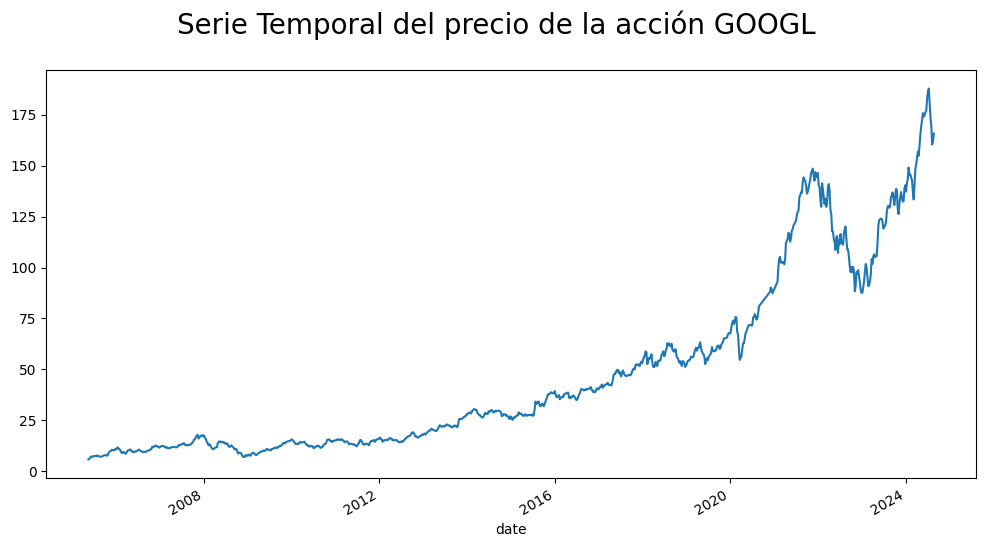

In [283]:
empresa ="GOOGL"
df_empresa = ML_data[ML_data["ticker"]==empresa]

fig, ax = plt.subplots(figsize=(12, 6))  # Crea la figura y el eje

# Graficar los datos
df_empresa["price_mean"].plot(ax=ax)

# Añadir un título al gráfico
fig.suptitle(f'Serie Temporal del precio de la acción {empresa}', fontsize=20)

# Ajustar el tamaño del gráfico si es necesario (esto se hace en la creación del gráfico)
# fig.set_size_inches(10, 8)  # Opcional: solo si necesitas cambiar el tamaño después de la creación

# Guardar el gráfico como imagen
fig.savefig(f'serie_temporal_precio{empresa}.png')

df_empresa =df_empresa.reset_index()

df_empresa.price_mean =df_empresa.price_mean.astype(float)


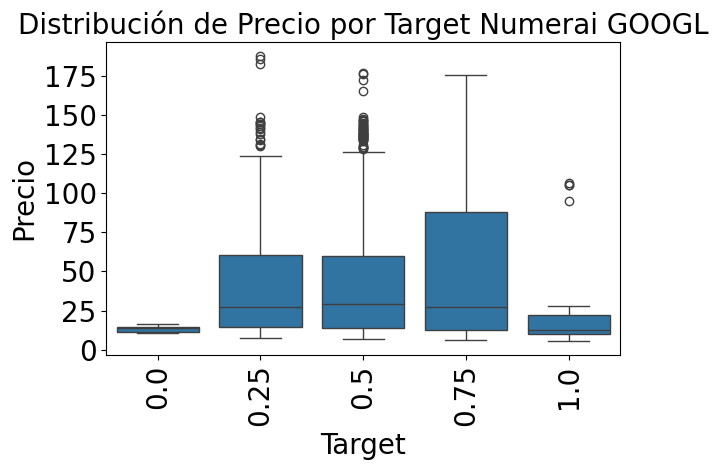

In [284]:

sns.boxplot(x='target_factor_neutral_20', y='price_mean', data=df_empresa)
plt.title(f'Distribución de Precio por Target Numerai {empresa}', fontsize=20)
plt.xlabel('Target', fontsize=20)
plt.ylabel('Precio', fontsize=20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
output_path = f'precio_por_taget_{empresa}.jpg'

# Mostrar el gráfico
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()

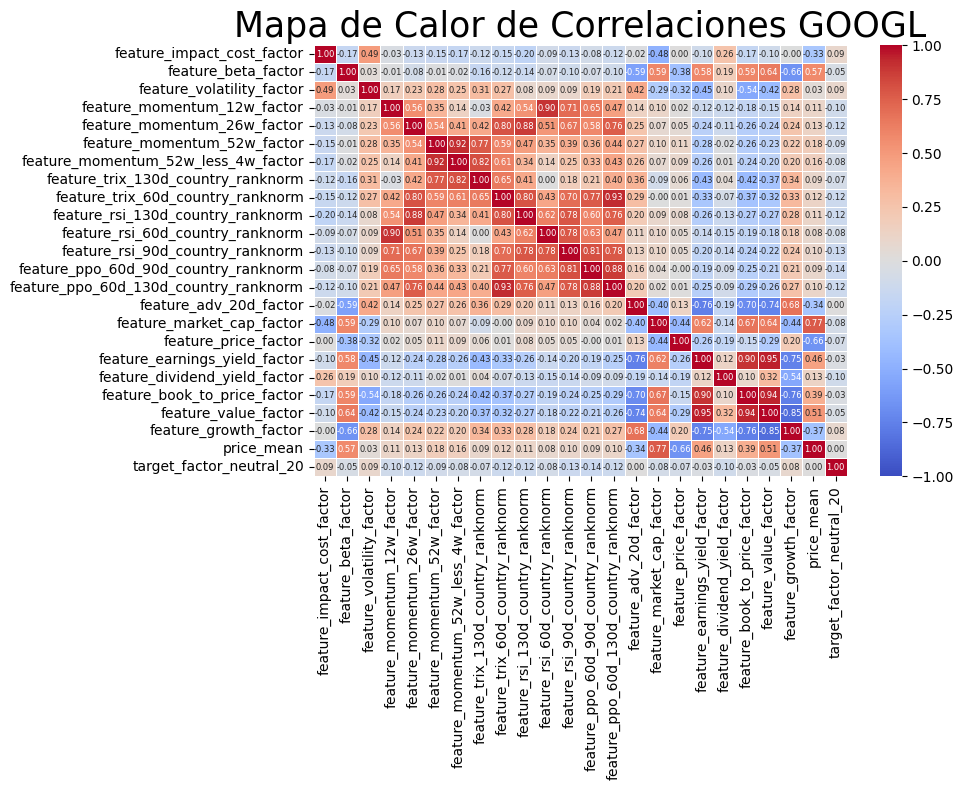

In [285]:
columns_analisis=['feature_impact_cost_factor', 'feature_beta_factor',
       'feature_volatility_factor', 'feature_momentum_12w_factor',
       'feature_momentum_26w_factor', 'feature_momentum_52w_factor',
       'feature_momentum_52w_less_4w_factor',
       'feature_trix_130d_country_ranknorm',
       'feature_trix_60d_country_ranknorm',
       'feature_rsi_130d_country_ranknorm', 'feature_rsi_60d_country_ranknorm',
       'feature_rsi_90d_country_ranknorm',
       'feature_ppo_60d_90d_country_ranknorm',
       'feature_ppo_60d_130d_country_ranknorm',
       'feature_adv_20d_factor', 'feature_market_cap_factor',
       'feature_price_factor', 'feature_earnings_yield_factor',
       'feature_dividend_yield_factor', 'feature_book_to_price_factor',
       'feature_value_factor', 'feature_growth_factor', 'price_mean', 'target_factor_neutral_20']

df_empresa = df_empresa[columns_analisis].copy()
corr_matrix = df_empresa.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', linewidths=0.5, annot_kws={"size": 6} )
plt.title('Mapa de Calor de Correlaciones GOOGL', fontsize=25)
output_path = 'correlaciones_GOOGL.jpg'

# Mostrar el gráfico
plt.tight_layout()
plt.savefig(output_path)
plt.show()